In [1]:
LENGTH = 7
WIDTH = 7
ZEROES_SIZE = (LENGTH * WIDTH, 3)

['./input/board0.JPG', './input/board4.JPG', './input/board3.JPG', './input/board5.JPG', './input/board2.JPG', './input/board1.JPG']


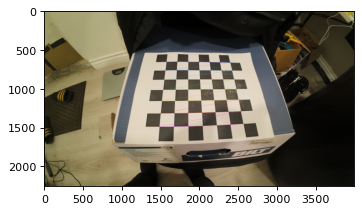

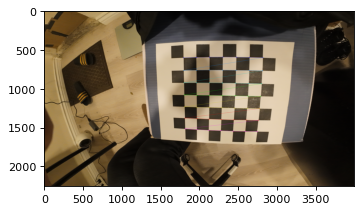

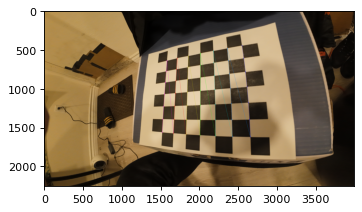

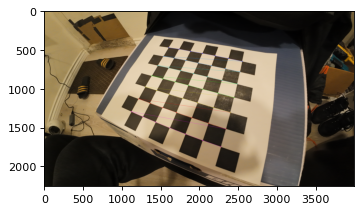

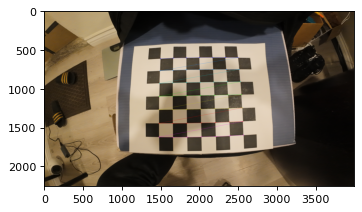

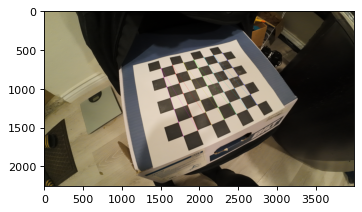

In [2]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros(ZEROES_SIZE, np.float32)
objp[:,:2] = np.mgrid[0:LENGTH,0:WIDTH].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('./input/board*.JPG')
print(images)
for fname in images:
    img = cv.imread(fname)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (LENGTH, WIDTH), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (LENGTH, WIDTH), corners2, ret)
        figure(figsize=(5,5), dpi=80)
        plt.imshow(img)
        plt.show()


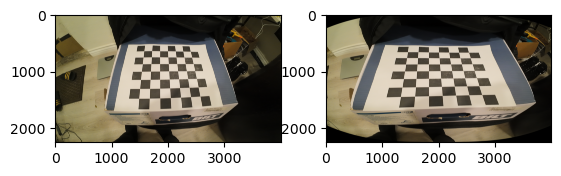

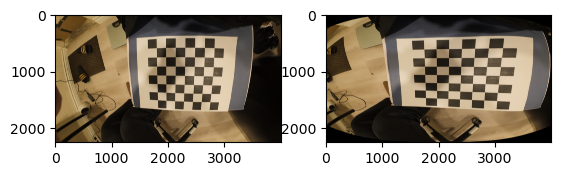

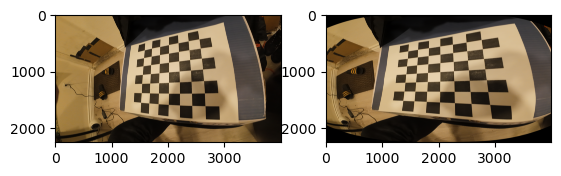

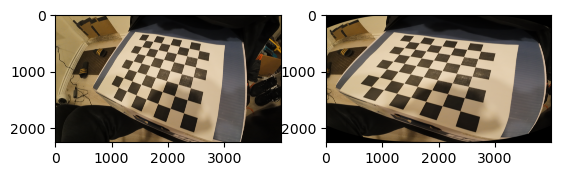

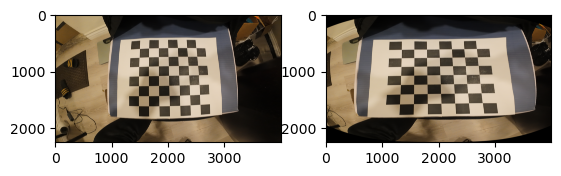

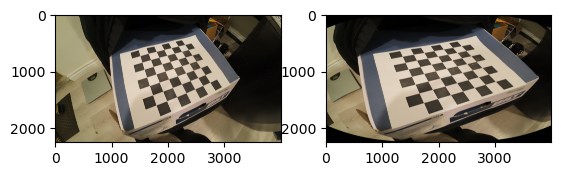

In [3]:
# Now given imagepoints and objectpoints, produce camera calibration matrix
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

img = cv.imread('./input/board0.JPG')
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# take test image and undistort
images = glob.glob('./input/board*.JPG')
for fname in images:
    img = cv.imread(fname)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
    dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(img)
    f.add_subplot(1,2, 2)
    plt.imshow(dst)
    plt.show(block=True)
# crop the image
#x, y, w, h = roi
#dst = dst[y:y+h, x:x+w]
# cv.imwrite('calibresult.png', dst)

##### Video Reading/Writing Functions


In [4]:
from typing import Generator
import os

def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv.VideoCapture(video_file)
    
    if video.isOpened(): 
        # get video property 
        width  = video.get(3)  # float `width`
        height = video.get(4)  # float `height`
        print("dimensions: ", width, " , ", height)

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()
    
# create cv2.VideoWriter object that we can use to save output video
def get_video_writer(target_video_path: str, fps: float, width: int, height: int) -> cv.VideoWriter:
    video_target_dir = os.path.dirname(os.path.abspath(target_video_path))
    os.makedirs(video_target_dir, exist_ok=True)
    return cv.VideoWriter(
        target_video_path, 
        fourcc=cv.VideoWriter_fourcc(*"mp4v"), 
        fps=fps, 
        frameSize=(width, height), 
        isColor=True
    )
    
def get_video_info(video_file = str) -> tuple[int ,int, float, int]:
    # get cv2.VideoCapture of source video
    video = cv.VideoCapture(video_file)
    width, height, fps = 0,0,0.0
    if video.isOpened(): 
        # get video property 
        width  = video.get(cv.CAP_PROP_FRAME_WIDTH)    # float width
        height = video.get(cv.CAP_PROP_FRAME_HEIGHT)   # float height
        fps = video.get(cv.CAP_PROP_FPS)               # float fps
        total = video.get(cv.CAP_PROP_FRAME_COUNT)     # int frames
    return int(width), int(height), fps, int(total)

Now we use an input video to calibrate the camera

In [16]:
from tqdm.notebook import tqdm
import pickle

# setup video 
calibration_input = './input/calibrationVideo.MP4'

frame_iterator = iter(generate_frames(video_file=calibration_input))
width, height, fps, total = get_video_info(calibration_input)

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros(ZEROES_SIZE, np.float32)
objp[:,:2] = np.mgrid[0:LENGTH,0:WIDTH].T.reshape(-1,2)
# Arrays to store object points and image points from all the images
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane

trueCounter = 0

for frame in tqdm(frame_iterator, total=total):
    gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (LENGTH, WIDTH), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        trueCounter += 1
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        if trueCounter == 100: break
        
print(trueCounter, "chessboards found out of", total)
        
        
# Now given imagepoints and objectpoints, produce camera calibration matrix
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (width,height), 1, (width,height))

with open('cameraCalibration.pkl', 'wb') as f:
    pickle.dump([ret, mtx, dist, rvecs, tvecs, newcameramtx, roi], f)


  0%|          | 0/1182 [00:00<?, ?it/s]

dimensions:  3840.0  ,  2160.0
853 chessboards found out of 1182


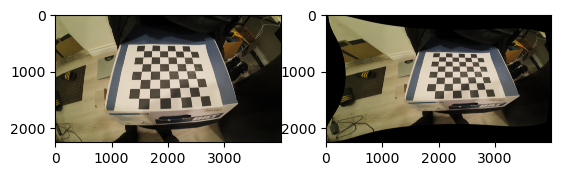

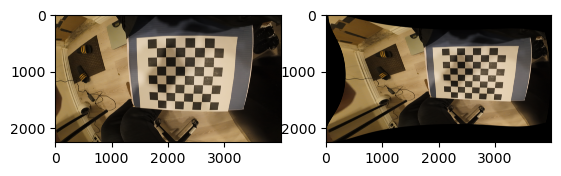

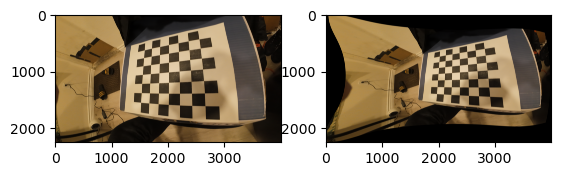

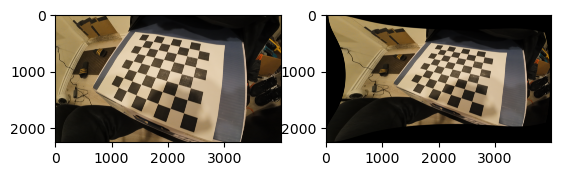

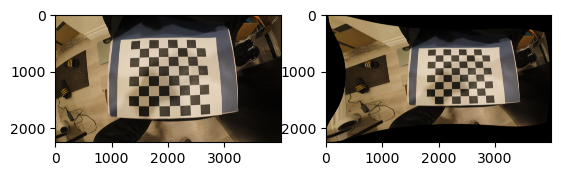

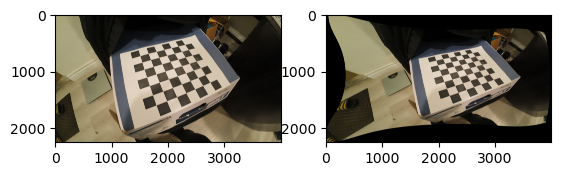

In [ ]:
# take test image and undistort
images = glob.glob('./input/board*.JPG')
for fname in images:
    img = cv.imread(fname)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
    dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(img)
    f.add_subplot(1,2, 2)
    plt.imshow(dst)
    plt.show(block=True)

We can then use the better calibration matrix to un-distort any footage from the camera

In [12]:
from tqdm.notebook import tqdm

video_file = './input/goproTest.MP4'

frame_iterator = iter(generate_frames(video_file=video_file))

# initiate video writer
width, height, fps, total = get_video_info(video_file)
print(width, height, fps, total)
video_writer = get_video_writer(
    target_video_path='./output/goproTest.MP4', 
    fps=fps,
    width=4000,
    height=2256)

for frame in tqdm(frame_iterator, total=total):
    # img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    
    dst = cv.remap(frame, mapx, mapy, cv.INTER_LINEAR)
        
    #print(dst.shape)
    
    video_writer.write(dst)
    
# close output video
video_writer.release()

3840 2160 59.94005994005994 1042


  0%|          | 0/1042 [00:00<?, ?it/s]

dimensions:  3840.0  ,  2160.0
